1. Run "pip install kaggle" 

2. Move "kaggle.json" to following Path /Users/linh/.kaggle

Importing relevent libraries

In [3]:
import pandas as pd 
from cleaning import *  # Import all functions from cleaning
import zipfile
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi  # Import Kaggle Api
import requests
from bs4 import BeautifulSoup
import seaborn as sb
import matplotlib.pyplot as plt

In [4]:
# Initiliaze API
api = KaggleApi()
api.authenticate()
api.model_list_cli()

# Donwload Dataset via API unzipped
api.dataset_download_files(dataset="alexteboul/heart-disease-health-indicators-dataset", unzip=True)

# Saving DataSets into DF
usa_df = pd.read_csv("heart_disease_health_indicators_BRFSS2015.csv")
india_df = pd.read_csv("./Data/CVD_india_data_raw.csv")

Next Page Token = CfDJ8KWOACvMaNFPiIJ818QpJK2iKzLN4ediml1AKhotFbL80_JUGEc5EevdxmLlV27Lyv9NKOcpbjFwUTuEpdX-kO0
    id  ref                                              title                            subtitle                                                                                                                                                                                                                                                       author                                  
------  -----------------------------------------------  -------------------------------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  --------------------------------------  
121027  metaresearch/llama-3.2                           Llama 3.2                        The Meta Llama 3.2 collectio

Scrape norm tables from Wikipedia

In [6]:
# blood pressure
url = "https://en.wikipedia.org/wiki/Blood_pressure"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

table = soup.find("table", class_="wikitable")

categories = []
office_data = []
relevant_data = False

for row in table.find_all('tr'):
    header_cells = row.find_all('th')
    if header_cells and "European Society of Cardiology" in header_cells[0].get_text():
        relevant_data = True
        continue
    if header_cells and "European Society of Hypertension" in header_cells[0].get_text():
        relevant_data = False
        break
    if relevant_data:
        data_cells = row.find_all('td')
        if len(data_cells) > 1:  # Ensures we have enough columns
            categories.append(data_cells[0].get_text(strip=True))
            office_data.append(data_cells[1].get_text(strip=True))

bp_df = pd.DataFrame({'Category': categories, 'Office': office_data})
bp_thresh = int(bp_df[bp_df['Category'] == 'Non-elevated']['Office'].values[0].split("<")[1])

In [7]:
# cholesterol
url = "https://en.wikipedia.org/wiki/Cholesterol"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

table = soup.find("table", class_="wikitable")
rows = table.find("tbody").find_all('tr')

chol_data = []
selected_rows = [1, 2, 3, 4]

for i in selected_rows:
    if i == 1:
        cell = rows[i].find('th').get_text(strip=True)
    else:
        cell = rows[i].find('td').get_text(strip=True)
    chol_data.append(cell)

chol_data
chol_thresh = int(chol_data[1].strip("< "))

Creating new binary columns for blood pressure and cholesterol in India data which match the US data

In [9]:
india_df["HighBP"] = india_df["restingBP"].apply(lambda x: 1 if x >= bp_thresh else 0)
print(india_df["HighBP"].unique())

india_df["HighChol"] = india_df["serumcholestrol"].apply(lambda x: 1 if x >= chol_thresh else 0)
print(india_df["HighChol"].unique())

india_df.head()

[1 0]
[0 1]


,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target,HighBP,HighChol
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1,1,0
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0,0,1
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0,1,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1,1,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1,1,0


Clean and Shaping Data

In [11]:
# apply functions for cleaning check
check_nan(india_df)
check_unique(india_df)
check_nan(usa_df)
check_unique(usa_df)

no missings in patientid
no missings in age
no missings in gender
no missings in chestpain
no missings in restingBP
no missings in serumcholestrol
no missings in fastingbloodsugar
no missings in restingrelectro
no missings in maxheartrate
no missings in exerciseangia
no missings in oldpeak
no missings in slope
no missings in noofmajorvessels
no missings in target
no missings in HighBP
no missings in HighChol


# of unique vals in patientid: 1000


# of unique vals in age: 61


# of unique vals in gender: 2
unique vals in gender: [0, 1]


# of unique vals in chestpain: 4
unique vals in chestpain: [0, 1, 2, 3]


# of unique vals in restingBP: 95


# of unique vals in serumcholestrol: 344


# of unique vals in fastingbloodsugar: 2
unique vals in fastingbloodsugar: [0, 1]


# of unique vals in restingrelectro: 3
unique vals in restingrelectro: [0, 1, 2]


# of unique vals in maxheartrate: 129


# of unique vals in exerciseangia: 2
unique vals in exerciseangia: [0, 1]


# of unique vals in 

In [12]:
# Synchronize matching columns
usa_df.columns = usa_df.columns.str.lower()
india_df.columns = india_df.columns.str.lower()

In [13]:
# Aligning Dtypes
usa_df = usa_df.apply(lambda x:x.astype(int))
india_df = india_df.apply(lambda x:x.astype(int, errors= "ignore"))

In [14]:
# Checking and konsolodate the columns
# Renaming India columns
india_df = india_df.rename(columns={"target":"cvd"})

# Renaming usa columns
usa_df = usa_df.rename(columns={"sex":"gender"})
usa_df = usa_df.rename(columns={"heartdiseaseorattack":"cvd"})

In [15]:
# assgning gender 
# sacrificing performance for readibility in this case int to object
gender = {
    1:"m",
    0:"f"
}
india_df["gender"] = india_df["gender"].map(gender)  
usa_df["gender"] = usa_df["gender"].map(gender)

In [16]:
# add country column to both dataframes
india_df['country'] = 'india'
usa_df['country'] = 'usa'

In [125]:
# Concantenate the DataFrames
merged = pd.concat([india_df, usa_df], axis=0, ignore_index=True)
# find common cols
common_columns = india_df.columns.intersection(usa_df.columns)
# drop all columns except those with data in both samples: age, gender, heartdiseaseorattack, highbp, highchol
merged = merged[common_columns]

# Function to map age to bins
def map_age_to_bin(age):
    if 18 <= age <= 24:
        return 1
    elif 25 <= age <= 29:
        return 2
    elif 30 <= age <= 34:
        return 3
    elif 35 <= age <= 39:
        return 4
    elif 40 <= age <= 44:
        return 5
    elif 45 <= age <= 49:
        return 6
    elif 50 <= age <= 54:
        return 7
    elif 55 <= age <= 59:
        return 8
    elif 60 <= age <= 64:
        return 9
    elif 65 <= age <= 69:
        return 10
    elif 70 <= age <= 74:
        return 11
    elif 75 <= age <= 79:
        return 12
    elif age >= 80:
        return 13
    else:
        return None

# apply function to india dataset
merged.loc[merged['country'] == 'india', 'age'] = merged.loc[merged['country'] == 'india', 'age'].apply(map_age_to_bin)

grouped = (merged.groupby("country")["age"].value_counts(normalize=True).sort_index() * 100).round()

# Print the percentage of each age value for India and USA separately
print(merged.head())

# save
merged.to_csv("./Data/merged_data.csv")

   age gender  cvd  highbp  highchol country
0    7      m    1       1         0   india
1    5      m    0       0         1   india
2    6      m    0       1         0   india
3    5      m    1       1         1   india
4    3      m    1       1         0   india


Data Analysis

Analysis on combined data

In [131]:
# compare demographics (age and gender distribution)
# Apply the function to the 'age' column
merged['age_range'] = merged['age'].apply(map_age_to_range)
merged.head()


,age,gender,cvd,highbp,highchol,country,age_range
0,7,m,1,1,0,india,50-54
1,5,m,0,0,1,india,40-44
2,6,m,0,1,0,india,45-49
3,5,m,1,1,1,india,40-44
4,3,m,1,1,0,india,30-34


   country    age_range  count
0    india        18-24    100
1    india        25-29     81
2    india        30-34     87
3    india        35-39     80
4    india        40-44     80
5    india        45-49     78
6    india        50-54     79
7    india        55-59     86
8    india        60-64     79
9    india        65-69     69
10   india        70-74     90
11   india        75-79     79
12   india  80 or older     12
13     usa        18-24   5700
14     usa        25-29   7598
15     usa        30-34  11123
16     usa        35-39  13823
17     usa        40-44  16157
18     usa        45-49  19819
19     usa        50-54  26314
20     usa        55-59  30832
21     usa        60-64  33244
22     usa        65-69  32194
23     usa        70-74  23533
24     usa        75-79  15980
25     usa  80 or older  17363
  country  total_count
0   india         1000
1     usa       253680

  country age_range  count  total_count
0   india     18-24    100         1000
1   india    

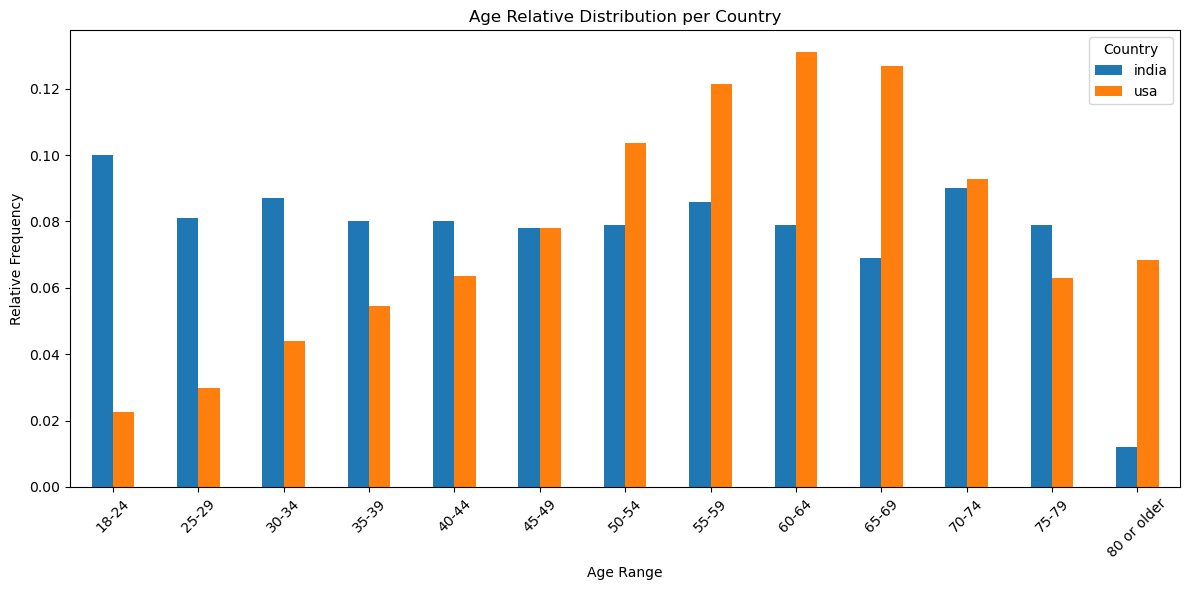

In [155]:
# age  plotting prep.:
# Calculate relative frequency for each age range per country

# calculate relative frequency for each age range per country
age_counts = merged.groupby(['country', 'age_range']).size().reset_index(name='count')
print(age_counts)

# Step 2: Calculate total count per country for relative frequency calculation
total_counts = age_counts.groupby('country')['count'].sum().reset_index(name='total_count')
print(total_counts.head())
print()

# Step 3: Merge the total counts back with the original counts
age_distribution = age_counts.merge(total_counts, on='country')
print(age_distribution.head())
print()

# Step 4: Calculate relative frequency
age_distribution['relative_frequency'] = age_distribution['count'] / age_distribution['total_count']
print(age_distribution.head())
print()

# Step 5: Create a pivot table for easier plotting
pivot_table = age_distribution.pivot(index='age_range', columns='country', values='relative_frequency')
print(pivot_table.head())
print()

# Plotting
pivot_table.plot(kind='bar', figsize=(12, 6))

# Customize plot
plt.title('Age Relative Distribution per Country')
plt.xlabel('Age Range')
plt.ylabel('Relative Frequency')
plt.xticks(rotation=45)
plt.legend(title='Country')
plt.tight_layout()

# Show plot
plt.show()

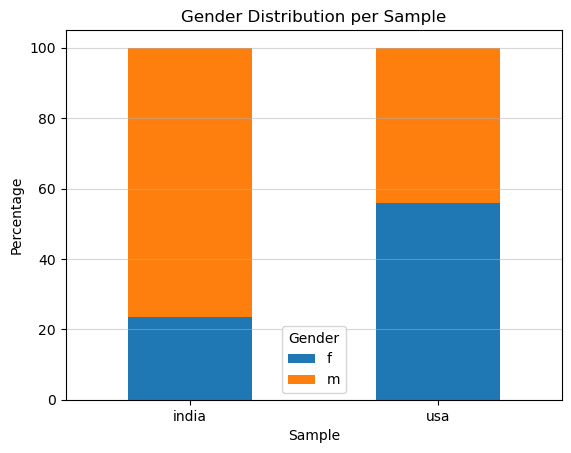

In [81]:
# compare demographics (age and gender distribution)

# GENDER
gender_counts = merged.groupby("country")["gender"].value_counts().unstack()
gender_perc = gender_counts.div(gender_counts.sum(axis=1), axis=0) * 100

gender_perc.plot(kind='bar', stacked=True)

plt.ylabel('Percentage')
plt.xlabel('Sample')
plt.title('Gender Distribution per Sample')
plt.xticks(rotation=False)
plt.legend(title='Gender')
plt.grid(axis = "y", alpha = 0.5)
plt.show()

In [187]:
# H1: The prevalence of high blood pressure is higher in the USA compared to India
# H2: The prevalence of high cholesterol is higher in the USA compared to India
# H3: The prevalence of heart disease is higher in the USA compared to India
grouped = (merged.groupby("country")[["highbp", "highchol", "cvd"]].mean() * 100).round(2)

print("Prevalence by Country:")
print(grouped)
print()

# Logical statements to compare the USA and India for each condition
print("H1.1: The prevalence of high blood pressure is higher in the US compared to India:", grouped.loc["usa", "highbp"] > grouped.loc["india", "highbp"])
print("H1.2: The prevalence of high cholesterol is higher in the US compared to India:", grouped.loc["usa", "highchol"] > grouped.loc["india", "highchol"])
print("H1.3: The prevalence of CVD is higher in the US compared to India:", grouped.loc["usa", "cvd"] > grouped.loc["india", "cvd"])

Prevalence by Country:
         highbp  highchol    cvd
country                         
india      89.4     82.40  58.00
usa        42.9     42.41   9.42

H1.1: The prevalence of high blood pressure is higher in the US compared to India: False
H1.2: The prevalence of high cholesterol is higher in the US compared to India: False
H1.3: The prevalence of CVD is higher in the US compared to India: False


Analysis on US sample

In [44]:
# H4: The prevalence of cvd is higher among smokers than non-smokers
smoker = usa_df[usa_df["smoker"] == 1]
non_smoker = usa_df[usa_df["smoker"] == 0]

# Calculating the percentage of individuals with heart disease in each group
cvd_smoker = (smoker["cvd"].mean()) * 100
cvd_non_smoker = (non_smoker["cvd"].mean()) * 100

print(f"CVD prevalence among smokers: {cvd_smoker:.2f}%")
print(f"CVD prevalence among non-smokers: {cvd_non_smoker:.2f}%")
print("H4: The prevalence of CVD is higher among smokers than non-smokers:" , cvd_smoker > cvd_non_smoker)

CVD prevalence among smokers: 13.17%
CVD prevalence among non-smokers: 6.44%
H4: The prevalence of CVD is higher among smokers than non-smokers: True


In [45]:
# Additional: The prevalence of cvd is higher among those with high BP
high_bp = usa_df[usa_df["highbp"] == 1]
no_high_bp = usa_df[usa_df["highbp"] == 0]

# Calculating the percentage of individuals with heart disease in each group
heart_disease_high_bp = (high_bp["cvd"].mean()) * 100
heart_disease_no_high_bp = (no_high_bp["cvd"].mean()) * 100

print(f"Percentage with heart disease among those with high BP: {heart_disease_high_bp:.2f}%")
print(f"Percentage with heart disease among those without high BP: {heart_disease_no_high_bp:.2f}%")
print("H5: The prevalence of CVD is higher among individuals with high BP:" , heart_disease_high_bp > heart_disease_no_high_bp)

Percentage with heart disease among those with high BP: 16.47%
Percentage with heart disease among those without high BP: 4.12%
H5: The prevalence of CVD is higher among individuals with high BP: True


In [159]:
# Additional: The prevalence of cvd is higher among those with high cholesterol
high_chol = usa_df[usa_df["highchol"] == 1]
no_high_chol = usa_df[usa_df["highchol"] == 0]

# Calculating the percentage of individuals with heart disease in each group
heart_disease_high_chol = (high_chol["cvd"].mean()) * 100
heart_disease_no_high_chol = (no_high_chol["cvd"].mean()) * 100

print(f"Percentage with heart disease among those with high BP: {heart_disease_high_chol:.2f}%")
print(f"Percentage with heart disease among those without high BP: {heart_disease_no_high_chol:.2f}%")
print("H5: The prevalence of CVD is higher among individuals with high cholesterol:" , heart_disease_high_chol > heart_disease_no_high_chol)

Percentage with heart disease among those with high BP: 15.57%
Percentage with heart disease among those without high BP: 4.89%
H5: The prevalence of CVD is higher among individuals with high cholesterol: True


Mean CVD prevalence in lower income groups (<$10k-$25k): 16.07%
Mean CVD prevalence in higher income groups ($35k-$75k+): 7.65%



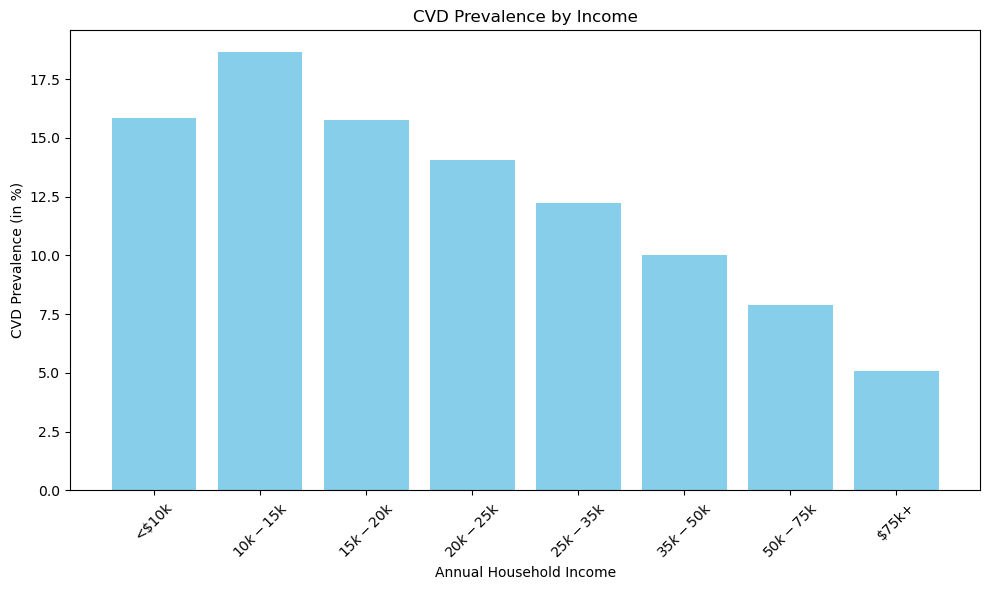

In [213]:
def map_amount_to_cat(income_cat):
    income_ranges = {1: '<$10k',
                     2: '$10k-$15k',
                     3: '$15k-$20k',
                     4: '$20k-$25k',
                     5: '$25k-$35k',
                     6: '$35k-$50k',
                     7: '$50k-$75k',
                     8: '$75k+'}
    return income_ranges.get(income_cat, 'Unknown')

# H5: The prevalence of cvd is higher among those with high cholesterol
income_us = usa_df.groupby('income')
cvd_count = income_us['cvd'].sum()
cvd_total = income_us['cvd'].count()
cvd_prev_income = (cvd_count / cvd_total)*100

# series to df
cvd_prev_income = cvd_prev_income.reset_index()

# rename cols
cvd_prev_income.columns = ['income', 'cvd_prevalence']

# Apply the mapping function to replace the income values
cvd_prev_income['income'] = cvd_prev_income['income'].apply(map_amount_to_cat)

# test hypothesis numerically
lower_income = cvd_prev_income[cvd_prev_income['income'].isin(['<$10k', '$10k-$15k', '$15k-$20k', '$20k-$25k'])]['cvd_prevalence'].mean()
higher_income = cvd_prev_income[cvd_prev_income['income'].isin(['$35k-$50k', '$50k-$75k', '$75k+'])]['cvd_prevalence'].mean()

print(f"Mean CVD prevalence in lower income groups (<$10k-$25k): {lower_income:.2f}%")
print(f"Mean CVD prevalence in higher income groups ($35k-$75k+): {higher_income:.2f}%")
print()

#plotting all income groups
plt.figure(figsize=(10, 6))
plt.bar(cvd_prev_income['income'], cvd_prev_income['cvd_prevalence'], color='skyblue')
plt.xlabel('Annual Household Income')
plt.ylabel('CVD Prevalence (in %)')
plt.title('CVD Prevalence by Income')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [163]:
usa_df.head()

,cvd,highbp,highchol,cholcheck,bmi,smoker,stroke,diabetes,physactivity,fruits,...,nodocbccost,genhlth,menthlth,physhlth,diffwalk,gender,age,education,income,country
0,0,1,1,1,40,1,0,0,0,0,...,0,5,18,15,1,f,9,4,3,usa
1,0,0,0,0,25,1,0,0,1,0,...,1,3,0,0,0,f,7,6,1,usa
2,0,1,1,1,28,0,0,0,0,1,...,1,5,30,30,1,f,9,4,8,usa
3,0,1,0,1,27,0,0,0,1,1,...,0,2,0,0,0,f,11,3,6,usa
4,0,1,1,1,24,0,0,0,1,1,...,0,2,3,0,0,f,11,5,4,usa


High Chol > in CVD than no CVD

In [46]:
india_df

,patientid,age,gender,chestpain,restingbp,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,cvd,highbp,highchol,country
0,103368,53,m,2,171,0,0,1,147,0,5,3,3,1,1,0,india
1,119250,40,m,0,94,229,0,1,115,0,3,1,1,0,0,1,india
2,119372,49,m,2,133,142,0,0,202,1,5,1,0,0,1,0,india
3,132514,43,m,0,138,295,1,1,153,0,3,2,2,1,1,1,india
4,146211,31,m,1,199,0,0,2,136,0,5,3,2,1,1,0,india
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9949544,48,m,2,139,349,0,2,183,1,5,2,2,1,1,1,india
996,9953423,47,m,3,143,258,1,1,98,1,5,1,0,0,1,1,india
997,9965859,69,m,0,156,434,1,0,196,0,1,3,1,1,1,1,india
998,9988507,45,m,1,186,417,0,1,117,1,5,3,2,1,1,1,india


Zusammenhänge 
RestingBP + Serumcholesterol + Max Heartrate + Age

HighBP + HighCholestoral + CVD # wie in USA

Boxplot 




In [82]:
india_grouped = india_df.groupby("cvd")[["highbp","highchol"]].sum()
india_grouped

,highbp,highchol
cvd,,
0,334,340
1,560,484


In [83]:
india_grouped= india_grouped.reset_index()

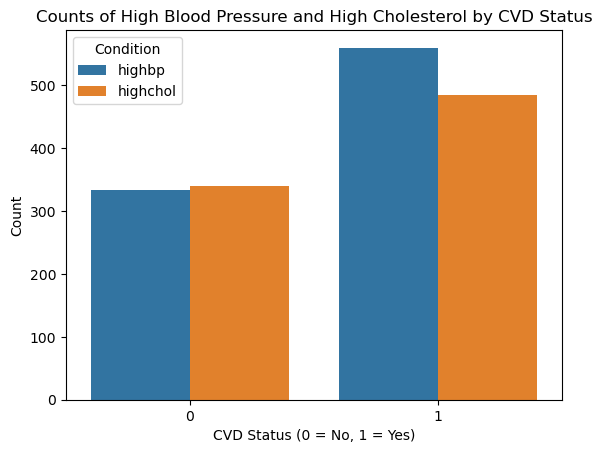

In [87]:
# Step 1: Reshape the data from wide format to long format for Seaborn
india_melted = india_grouped.melt(id_vars="cvd", 
                                  value_vars=["highbp", "highchol"], 
                                  var_name="Condition", 
                                  value_name="Count")

# Step 2: Plot using Seaborn
sns.barplot(x="cvd", y="Count", hue="Condition", data=india_melted)
plt.title('Counts of High Blood Pressure and High Cholesterol by CVD Status')
plt.xlabel('CVD Status (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='cvd'>

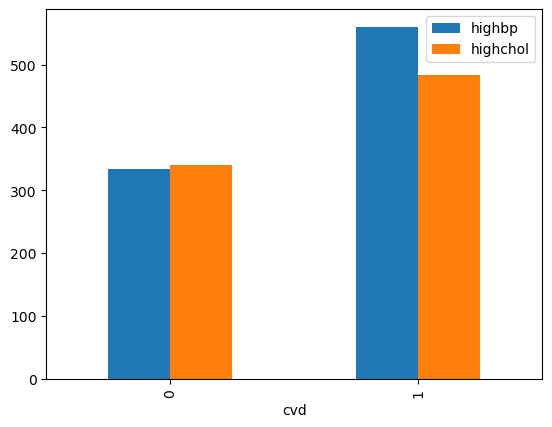

In [62]:
india_grouped.plot(kind="bar")

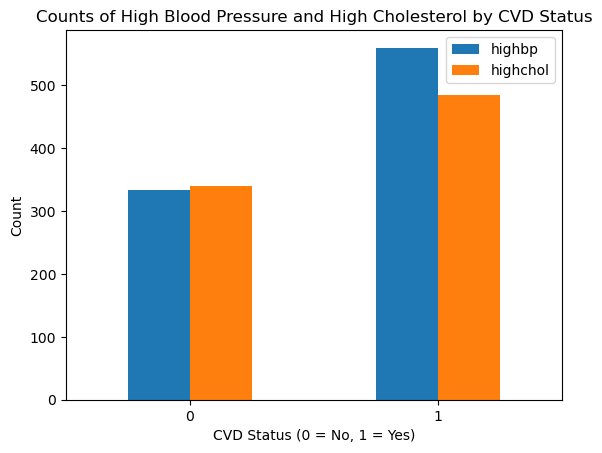

In [61]:
# Assuming india_grouped is the summarized DataFrame you showed
# Plotting the data using the existing table format
india_grouped.plot(kind="bar")
plt.title('Counts of High Blood Pressure and High Cholesterol by CVD Status')
plt.ylabel('Count')
plt.xlabel('CVD Status (0 = No, 1 = Yes)')
plt.xticks(rotation=0)
plt.show()

In [53]:
sb.barplot(x=["highbp","highchol","cvd"],data= india_grouped)

ValueError: Length of list vectors must match length of `data` when both are used, but `data` has length 2 and the vector passed to `x` has length 3.

In [48]:
# H6: The prevalence of cvd is higher among those with high chol

Visualizing the Data

In [49]:
# Defining relevant Plots